Kyle Evenson, Amy Chatterjee, Azlena Lim

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import * # from plotnin e library import all functions
from scipy.stats import ttest_ind # from scipy.stats import a two sample t test function
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # autocorrelation and partial autocorrelation functions

from statsmodels.iolib import summary2

import pandas_datareader as pdr

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()

In [2]:
# Import shipment data
df = pd.read_excel('https://raw.githubusercontent.com/robertasgabrys/DSO424Fall2023/main/CompetitionData.xlsx')
df.head()

Tavg  Tmed  Tmax  Tmin       Load
0    43  43.0  60.0  31.0  1384494.0
1    42  42.0  58.0  29.0  1392822.0
2    41  41.0  57.0  31.0  1407887.0
3    41  41.0  56.0  30.0  1438658.0
4    40  41.0  53.0  29.0  1484046.0

## EDA

In [3]:
df.shape

(43824, 5)

In [4]:
43824/24/365

5.002739726027397

In [5]:
43824/5*4

35059.2

In [6]:
df.loc[35064]

Tavg    60.0
Tmed    60.0
Tmax    68.0
Tmin    55.0
Load     NaN
Name: 35064, dtype: float64

In [7]:
35064/4
# There are 8760 hours per year, plus 6 to account for leap year.
# 2006 does not have there

8766.0

In [8]:
43824-4*(8766)

8760

In [9]:
df_time = pd.DataFrame({'Hours': pd.date_range('2002-01-01', '2007-01-01', freq='1H', inclusive='left')})
df_time.tail()


Hours
43819 2006-12-31 19:00:00
43820 2006-12-31 20:00:00
43821 2006-12-31 21:00:00
43822 2006-12-31 22:00:00
43823 2006-12-31 23:00:00

In [27]:
df_new = pd.merge(df_time, df, left_index=True, right_index = True)
df_new.head()
df2 = df_new

In [11]:
df_indexed = df_new.set_index('Hours')
df_indexed

Tavg  Tmed  Tmax  Tmin       Load
Hours                                                 
2002-01-01 00:00:00    43  43.0  60.0  31.0  1384494.0
2002-01-01 01:00:00    42  42.0  58.0  29.0  1392822.0
2002-01-01 02:00:00    41  41.0  57.0  31.0  1407887.0
2002-01-01 03:00:00    41  41.0  56.0  30.0  1438658.0
2002-01-01 04:00:00    40  41.0  53.0  29.0  1484046.0
...                   ...   ...   ...   ...        ...
2006-12-31 19:00:00    71  72.0  77.0  65.0        NaN
2006-12-31 20:00:00    70  72.0  75.0  65.0        NaN
2006-12-31 21:00:00    70  71.0  75.0  65.0        NaN
2006-12-31 22:00:00    69  70.0  74.0  65.0        NaN
2006-12-31 23:00:00    69  70.0  73.0  64.0        NaN

[43824 rows x 5 columns]

/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 8760 rows containing missing values.
/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 8760 rows containing missing values.


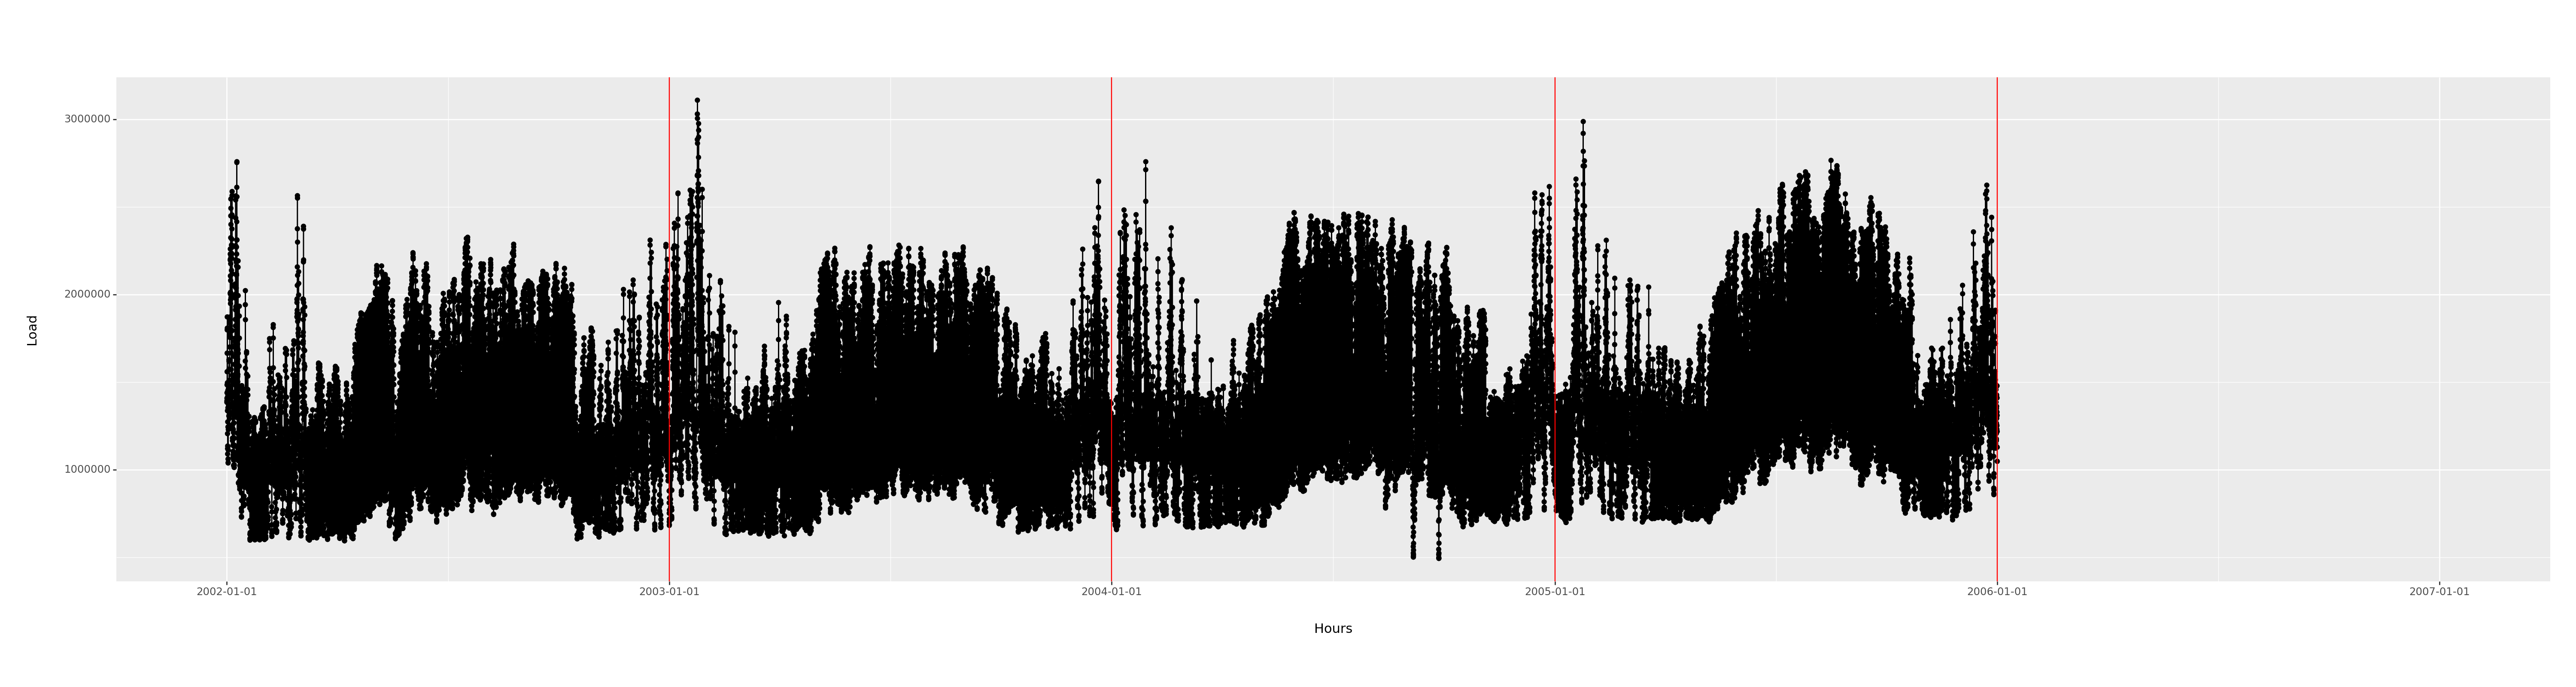

<Figure Size: (3000 x 800)>

In [12]:
ggplot(df_new, aes('Hours','Load')) + geom_point() + geom_line() + \
                geom_vline(xintercept = df_new.loc[8761, 'Hours'], color = 'red') + \
                geom_vline(xintercept = df_new.loc[17521, 'Hours'], color = 'red') + \
                geom_vline(xintercept = df_new.loc[26305, 'Hours'], color = 'red') + \
                geom_vline(xintercept = df_new.loc[35065, 'Hours'], color = 'red') + \
                theme(figure_size=(30, 8))

                # geom_point(aes('EndDate','M2'), color = 'purple') + \
                # geom_line(aes('EndDate','M2'), color = 'lavender') + \
                # geom_point(aes('EndDate','M3'), color = 'blue') + \
                # geom_line(aes('EndDate','M3'), color = 'lightskyblue') + \
                # geom_point(aes('EndDate','M4'), color = 'green') + \
                # geom_line(aes('EndDate','M4'), color = 'yellowgreen') + \
                # geom_point(aes('EndDate','M5'), color = 'gold') + \
                # geom_line(aes('EndDate','M5'), color = 'yellow')

In [13]:
df_indexed.loc[df_indexed['Load'] <= 580000]

Tavg  Tmed  Tmax  Tmin      Load
Hours                                                
2004-09-06 00:00:00    78  78.0  81.0  75.0  560384.0
2004-09-06 01:00:00    78  78.0  83.0  75.0  523221.0
2004-09-06 02:00:00    78  78.0  83.0  75.0  502469.0
2004-09-06 03:00:00    78  78.0  83.0  75.0  500043.0
2004-09-06 04:00:00    78  78.0  83.0  75.0  507690.0
2004-09-06 05:00:00    77  77.0  83.0  74.0  516157.0
2004-09-06 06:00:00    77  77.0  83.0  74.0  540000.0
2004-09-06 07:00:00    78  77.0  84.0  74.0  578586.0
2004-09-27 00:00:00    75  77.0  80.0  69.0  544700.0
2004-09-27 01:00:00    75  76.0  79.0  68.0  514508.0
2004-09-27 02:00:00    75  74.0  79.0  70.0  497768.0
2004-09-27 03:00:00    75  74.0  79.0  69.0  492907.0
2004-09-27 04:00:00    75  75.0  79.0  69.0  493158.0
2004-09-27 05:00:00    75  75.0  79.0  71.0  522464.0
2004-09-27 06:00:00    75  75.0  79.0  71.0  579609.0

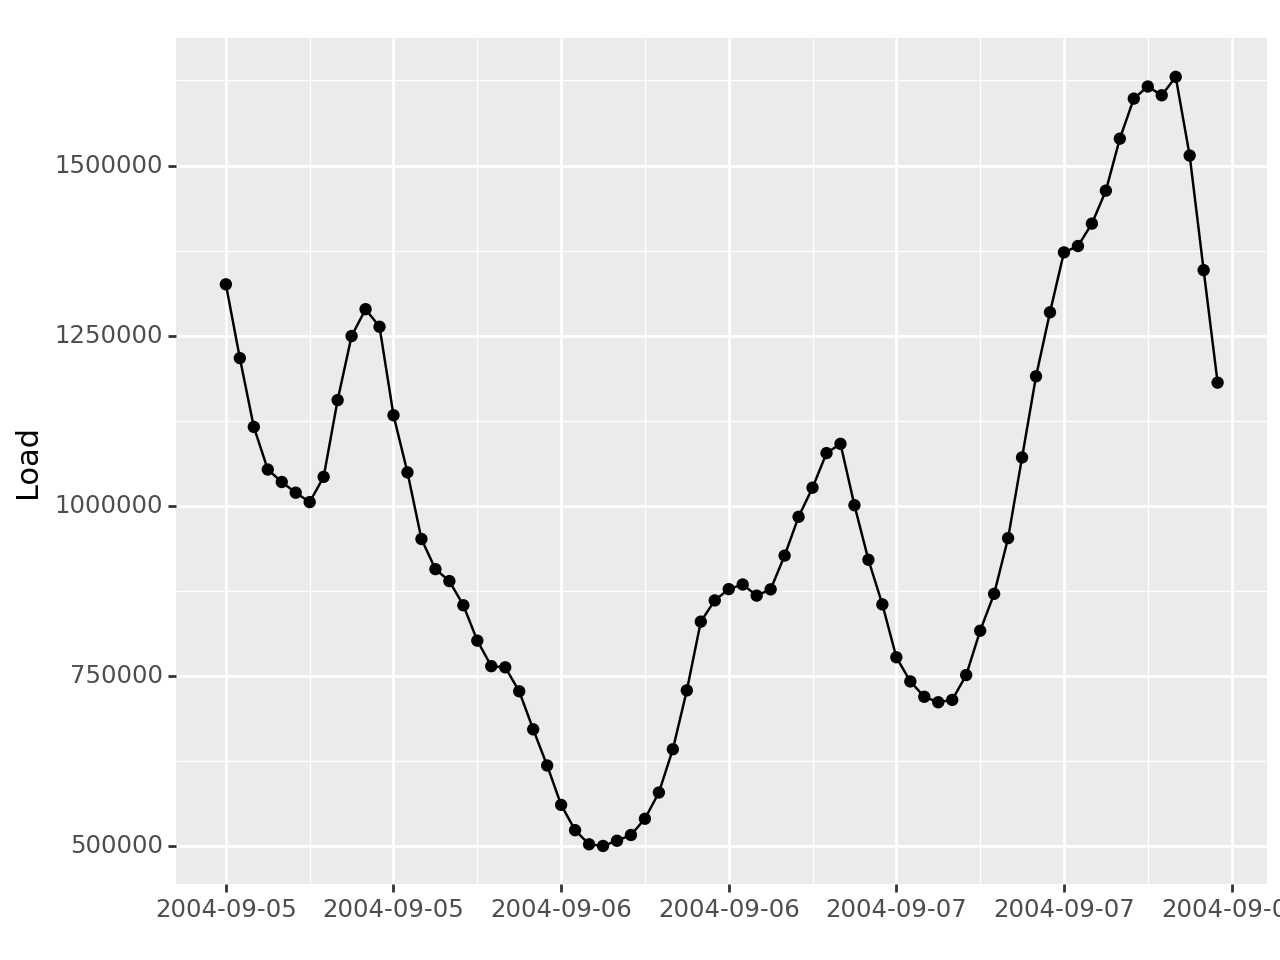

<Figure Size: (640 x 480)>

In [14]:
ggplot(df_indexed.loc['2004-09-05 00:00:00':'2004-09-07 23:00:00'], aes(df_indexed.loc['2004-09-05 00:00:00':'2004-09-07 23:00:00'].index,'Load')) + geom_point() + geom_line()

In [15]:
ggplot(df_indexed.loc['2004-09-26 00:00:00':'2004-09-28 23:00:00'], aes(df_indexed.loc['2004-09-26 00:00:00':'2004-09-28 23:00:00'].index,'Load')) + geom_point() + geom_line()

<Figure Size: (640 x 480)>

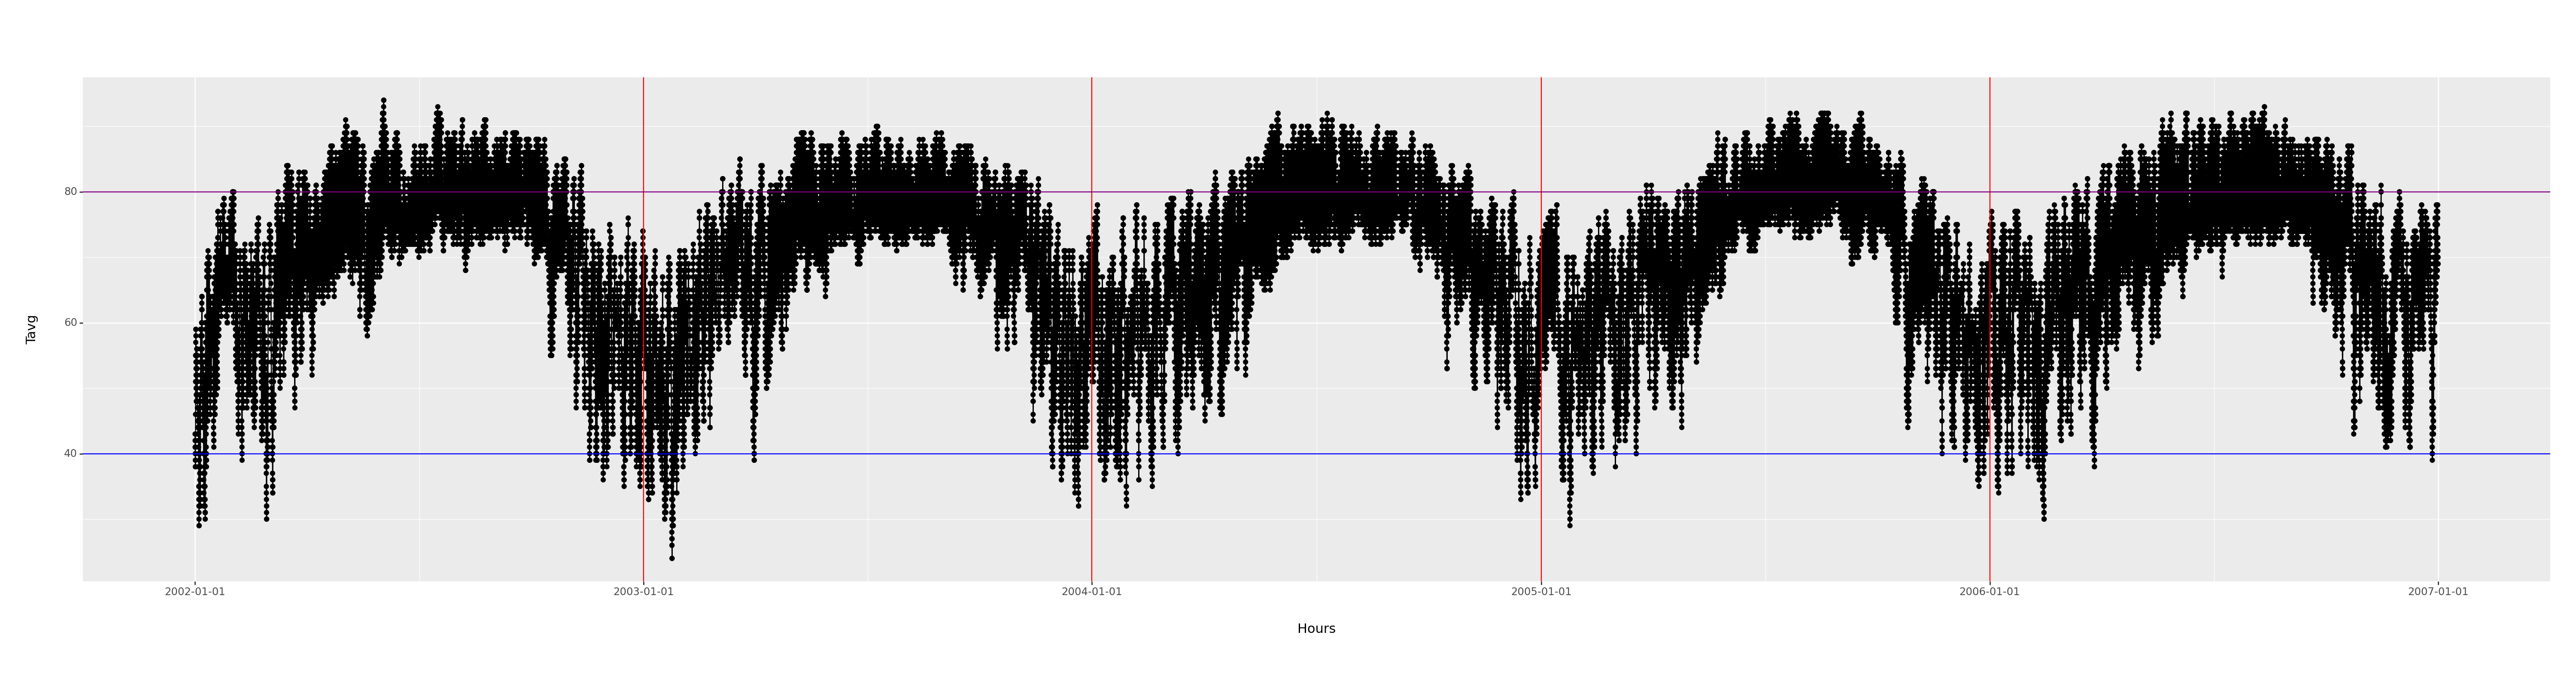

<Figure Size: (3000 x 800)>

In [16]:
ggplot(df_new, aes('Hours','Tavg')) + geom_point() + geom_line() + \
                geom_vline(xintercept = df_new.loc[8761, 'Hours'], color = 'red') + \
                geom_vline(xintercept = df_new.loc[17521, 'Hours'], color = 'red') + \
                geom_vline(xintercept = df_new.loc[26305, 'Hours'], color = 'red') + \
                geom_vline(xintercept = df_new.loc[35065, 'Hours'], color = 'red') + \
                geom_hline(yintercept = 40, color = 'blue') + \
                geom_hline(yintercept = 80, color = 'purple') + \
                theme(figure_size=(30, 8))

                # geom_point(aes('EndDate','M2'), color = 'purple') + \
                # geom_line(aes('EndDate','M2'), color = 'lavender') + \
                # geom_point(aes('EndDate','M3'), color = 'blue') + \
                # geom_line(aes('EndDate','M3'), color = 'lightskyblue') + \
                # geom_point(aes('EndDate','M4'), color = 'green') + \
                # geom_line(aes('EndDate','M4'), color = 'yellowgreen') + \
                # geom_point(aes('EndDate','M5'), color = 'gold') + \
                # geom_line(aes('EndDate','M5'), color = 'yellow')

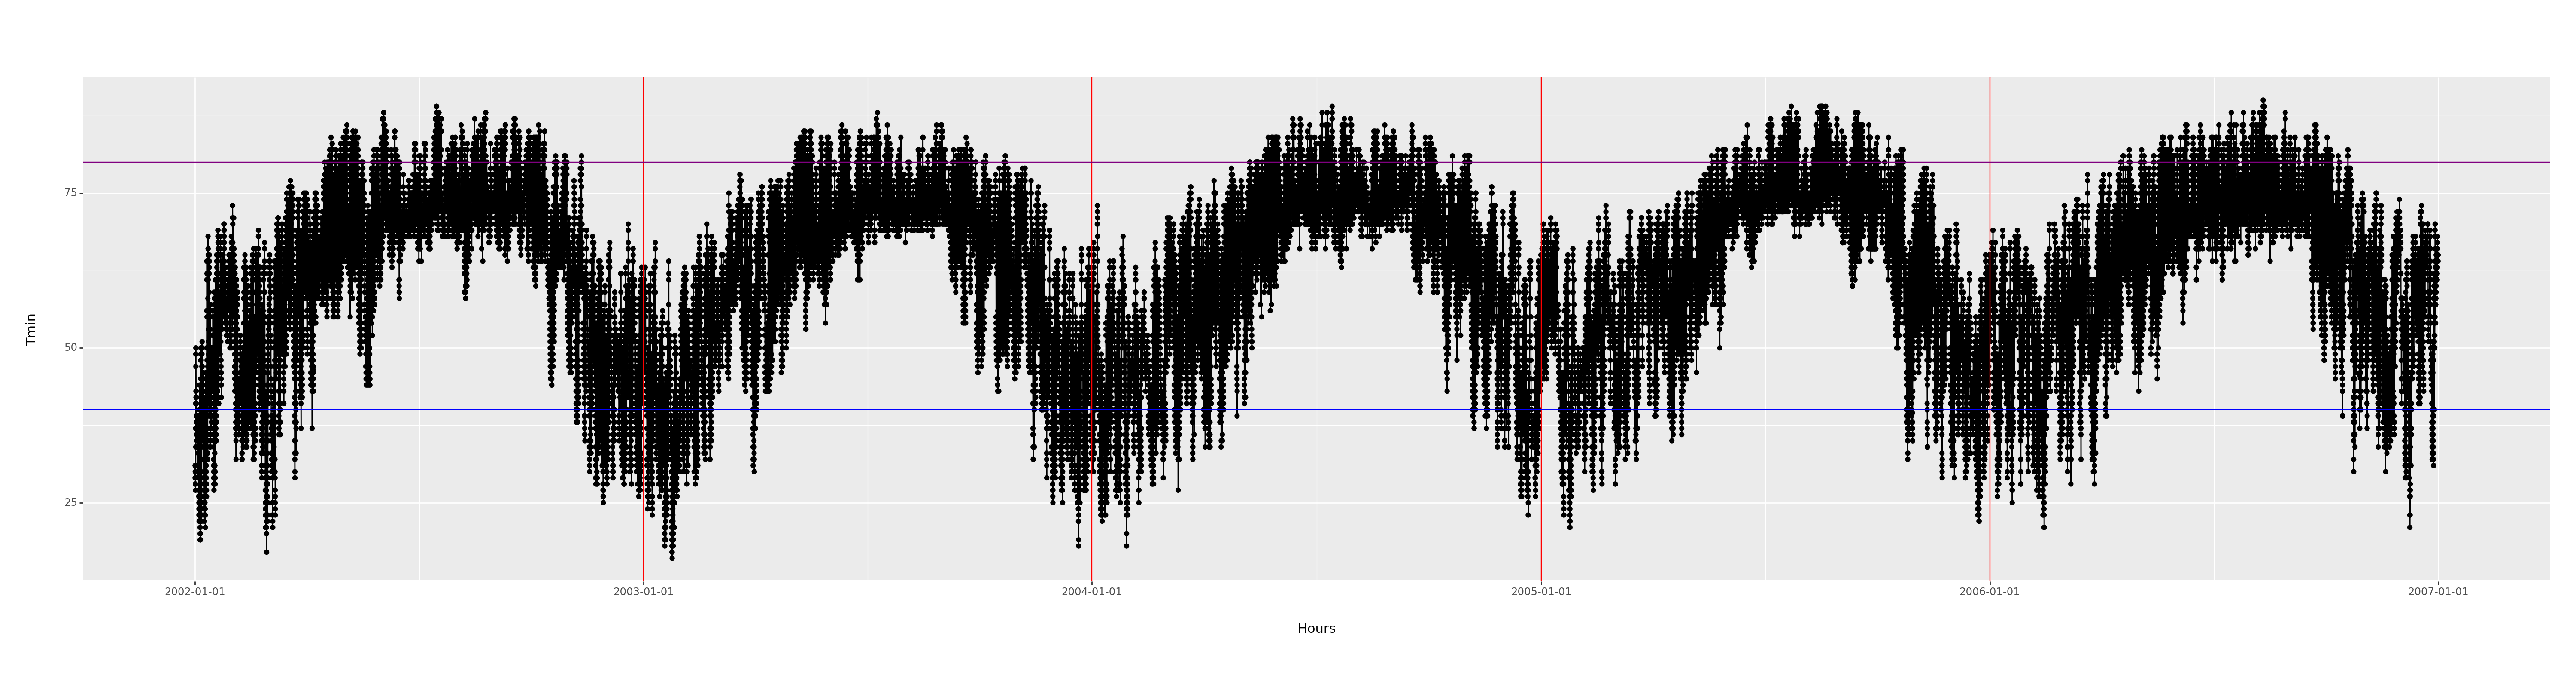

<Figure Size: (3000 x 800)>

In [17]:
ggplot(df_new, aes('Hours','Tmin')) + geom_point() + geom_line() + \
                geom_vline(xintercept = df_new.loc[8761, 'Hours'], color = 'red') + \
                geom_vline(xintercept = df_new.loc[17521, 'Hours'], color = 'red') + \
                geom_vline(xintercept = df_new.loc[26305, 'Hours'], color = 'red') + \
                geom_vline(xintercept = df_new.loc[35065, 'Hours'], color = 'red') + \
                geom_hline(yintercept = 40, color = 'blue') + \
                geom_hline(yintercept = 80, color = 'purple') + \
                theme(figure_size=(30, 8))

                # geom_point(aes('EndDate','M2'), color = 'purple') + \
                # geom_line(aes('EndDate','M2'), color = 'lavender') + \
                # geom_point(aes('EndDate','M3'), color = 'blue') + \
                # geom_line(aes('EndDate','M3'), color = 'lightskyblue') + \
                # geom_point(aes('EndDate','M4'), color = 'green') + \
                # geom_line(aes('EndDate','M4'), color = 'yellowgreen') + \
                # geom_point(aes('EndDate','M5'), color = 'gold') + \
                # geom_line(aes('EndDate','M5'), color = 'yellow')

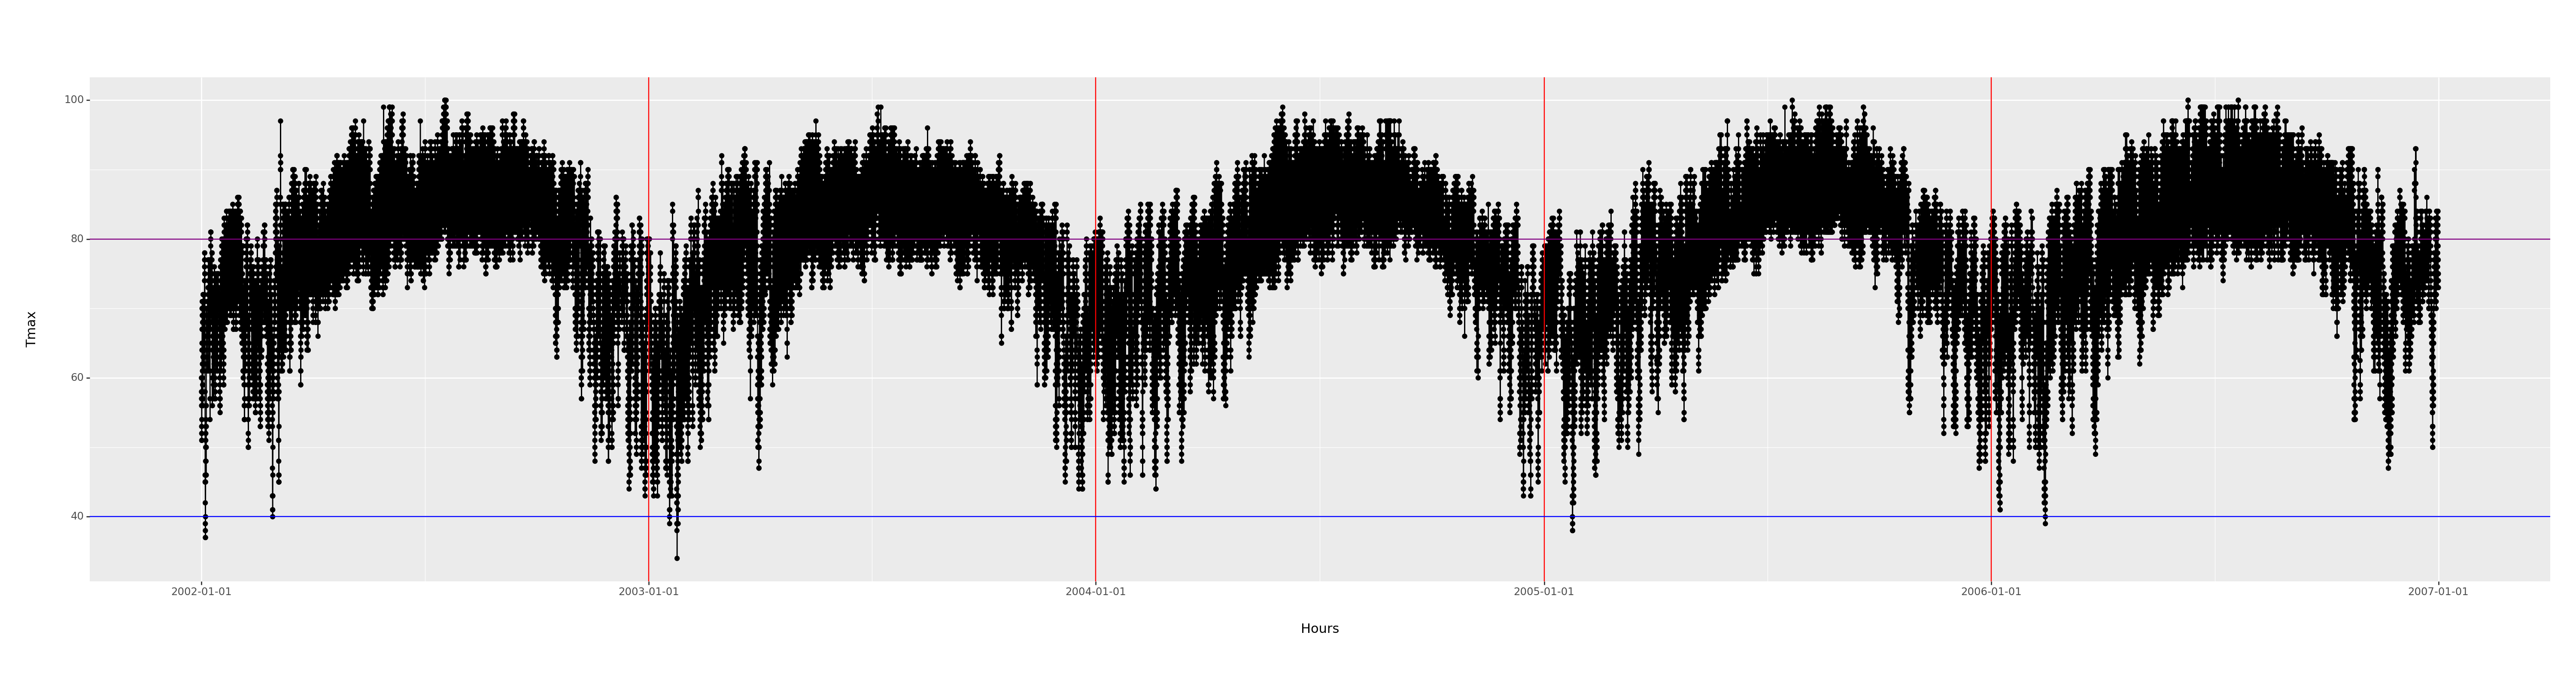

<Figure Size: (3000 x 800)>

In [18]:
ggplot(df_new, aes('Hours','Tmax')) + geom_point() + geom_line() + \
                geom_vline(xintercept = df_new.loc[8761, 'Hours'], color = 'red') + \
                geom_vline(xintercept = df_new.loc[17521, 'Hours'], color = 'red') + \
                geom_vline(xintercept = df_new.loc[26305, 'Hours'], color = 'red') + \
                geom_vline(xintercept = df_new.loc[35065, 'Hours'], color = 'red') + \
                geom_hline(yintercept = 40, color = 'blue') + \
                geom_hline(yintercept = 80, color = 'purple') + \
                theme(figure_size=(30, 8))

                # geom_point(aes('EndDate','M2'), color = 'purple') + \
                # geom_line(aes('EndDate','M2'), color = 'lavender') + \
                # geom_point(aes('EndDate','M3'), color = 'blue') + \
                # geom_line(aes('EndDate','M3'), color = 'lightskyblue') + \
                # geom_point(aes('EndDate','M4'), color = 'green') + \
                # geom_line(aes('EndDate','M4'), color = 'yellowgreen') + \
                # geom_point(aes('EndDate','M5'), color = 'gold') + \
                # geom_line(aes('EndDate','M5'), color = 'yellow')

In [19]:
df_new['Yearly_Average'] = 0
df_new.loc[:8759,'Yearly_Average'] = df_new.loc[:8759, 'Load'].mean()
df_new.loc[8760:17519,'Yearly_Average'] = df_new.loc[8760:17519, 'Load'].mean()
df_new.loc[17520:26303,'Yearly_Average'] = df_new.loc[17520:26303, 'Load'].mean()
df_new.loc[26304:35063,'Yearly_Average'] = df_new.loc[26304:35063, 'Load'].mean()
# Extra Day (Leap Year) at index 1416 + 17520 = 18936:18959
df_new['Year'] = df_new['Hours'].dt.year
df_new['Month'] = df_new['Hours'].dt.month
df_new['Week'] = df_new['Hours'].dt.week
df_new['Day'] = df_new['Hours'].dt.day
df_new['Day_of_week'] = df_new['Hours'].dt.dayofweek
# Can include below with normal date without time
holidays = cal.holidays(start='2002-01-01', end='2006-12-31')
df_new['Holiday'] = df_new['Hours'].isin(holidays)
df_new['Weekend'] = df_new['Hours'].dt.dayofweek > 4
df_new['Daily_Increase'] = range(1,len(df) + 1,1)
df_new['iga78'] = np.where(df_new['Tavg'] >= 78, True, False)
df_new['iga79'] = np.where(df_new['Tavg'] >= 79, True, False)
df_new['iga80'] = np.where(df_new['Tavg'] >= 80, True, False)
df_new['iga81'] = np.where(df_new['Tavg'] >= 81, True, False)
df_new['iga82'] = np.where(df_new['Tavg'] >= 82, True, False)
df_new['iga83'] = np.where(df_new['Tavg'] >= 83, True, False)
df_new['iga84'] = np.where(df_new['Tavg'] >= 84, True, False)
df_new['iga85'] = np.where(df_new['Tavg'] >= 85, True, False)
df_new['igb40'] = np.where(df_new['Tavg'] <= 40, True, False)
df_new['igb41'] = np.where(df_new['Tavg'] <= 41, True, False)
df_new['igb42'] = np.where(df_new['Tavg'] <= 42, True, False)
df_new['igb43'] = np.where(df_new['Tavg'] <= 43, True, False)
df_new['igb44'] = np.where(df_new['Tavg'] <= 44, True, False)
df_new['igb45'] = np.where(df_new['Tavg'] <= 45, True, False)
df_new['igb46'] = np.where(df_new['Tavg'] <= 46, True, False)
df_new['igb47'] = np.where(df_new['Tavg'] <= 47, True, False)
df_new['outliers'] = np.where(((df_new['Hours'] >= '2004-09-05 16:00:00') & (df_new['Hours'] <= '2004-09-06 09:00:00')) | \
                              ((df_new['Hours'] >= '2004-09-26 19:00:00') & (df_new['Hours'] <= '2004-09-27 09:00:00')), True, False)
df_new['outliers1'] = np.where(((df_new['Hours'] >= '2004-09-05 16:00:00') & (df_new['Hours'] <= '2004-09-06 09:00:00')), True, False)
df_new['outliers2'] = np.where(((df_new['Hours'] >= '2004-09-26 19:00:00') & (df_new['Hours'] <= '2004-09-27 09:00:00')), True, False)

# df_new['Daily_Increase'] =
# df_new['']

<ipython-input-19-8b2b4432b538>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.


In [20]:
df_new.loc[(df_new['Hours'] >= '2004-09-05 13:00:00') & (df_new['Hours'] <= '2004-09-06 09:00:00')]

Hours  Tavg  Tmed  Tmax  Tmin       Load  Yearly_Average  \
23485 2004-09-05 13:00:00    80  78.0  91.0  73.0  1049078.0    1.366839e+06   
23486 2004-09-05 14:00:00    79  78.0  91.0  73.0   951131.0    1.366839e+06   
23487 2004-09-05 15:00:00    79  78.0  90.0  73.0   906847.0    1.366839e+06   
23488 2004-09-05 16:00:00    78  78.0  91.0  72.0   889270.0    1.366839e+06   
23489 2004-09-05 17:00:00    77  77.0  88.0  71.0   853735.0    1.366839e+06   
23490 2004-09-05 18:00:00    77  77.0  87.0  72.0   801794.0    1.366839e+06   
23491 2004-09-05 19:00:00    77  77.0  86.0  73.0   764244.0    1.366839e+06   
23492 2004-09-05 20:00:00    77  77.0  84.0  74.0   762563.0    1.366839e+06   
23493 2004-09-05 21:00:00    77  77.0  82.0  75.0   727318.0    1.366839e+06   
23494 2004-09-05 22:00:00    78  78.0  82.0  75.0   671415.0    1.366839e+06   
23495 2004-09-05 23:00:00    78  78.0  82.0  75.0   618271.0    1.366839e+06   
23496 2004-09-06 00:00:00    78  78.0  81.0  75.0   560384.0    1.366839e+06   
23497 2004-09-06 01:00:00    78  78.0  83.0  75.0   523221.0    1.366839e+06   
23498 2004-09-06 02:00:00    78  78.0  83.0  75.0   502469.0    1.366839e+06   
23499 2004-09-06 03:00:00    78  78.0  83.0  75.0   500043.0    1.366839e+06   
23500 2004-09-06 04:00:00    78  78.0  83.0  75.0   507690.0    1.366839e+06   
23501 2004-09-06 05:00:00    77  77.0  83.0  74.0   516157.0    1.366839e+06   
23502 2004-09-06 06:00:00    77  77.0  83.0  74.0   540000.0    1.366839e+06   
23503 2004-09-06 07:00:00    78  77.0  84.0  74.0   578586.0    1.366839e+06   
23504 2004-09-06 08:00:00    78  77.0  84.0  75.0   642169.0    1.366839e+06   
23505 2004-09-06 09:00:00    78  77.0  86.0  75.0   728632.0    1.366839e+06   

       Year  Month  Week  ...  igb41  igb42  igb43  igb44  igb45  igb46  \
23485  2004      9    36  ...  False  False  False  False  False  False   
23486  2004      9    36  ...  False  False  False  False  False  False   
23487  2004      9    36  ...  False  False  False  False  False  False   
23488  2004      9    36  ...  False  False  False  False  False  False   
23489  2004      9    36  ...  False  False  False  False  False  False   
23490  2004      9    36  ...  False  False  False  False  False  False   
23491  2004      9    36  ...  False  False  False  False  False  False   
23492  2004      9    36  ...  False  False  False  False  False  False   
23493  2004      9    36  ...  False  False  False  False  False  False   
23494  2004      9    36  ...  False  False  False  False  False  False   
23495  2004      9    36  ...  False  False  False  False  False  False   
23496  2004      9    37  ...  False  False  False  False  False  False   
23497  2004      9    37  ...  False  False  False  False  False  False   
23498  2004      9    37  ...  False  False  False  False  False  False   
23499  2004      9    37  ...  False  False  False  False  False  False   
23500  2004      9    37  ...  False  False  False  False  False  False   
23501  2004      9    37  ...  False  False  False  False  False  False   
23502  2004      9    37  ...  False  False  False  False  False  False   
23503  2004      9    37  ...  False  False  False  False  False  False   
23504  2004      9    37  ...  False  False  False  False  False  False   
23505  2004      9    37  ...  False  False  False  False  False  False   

       igb47  outliers  outliers1  outliers2  
23485  False     False      False      False  
23486  False     False      False      False  
23487  False     False      False      False  
23488  False      True       True      False  
23489  False      True       True      False  
23490  False      True       True      False  
23491  False      True       True      False  
23492  False      True       True      False  
23493  False      True       True      False  
23494  False      True       True      False  
23495  False      True       True      False  
23496  False      True       True      False

In [21]:
df_new['Hour'] = df_new['Hours'].dt.hour

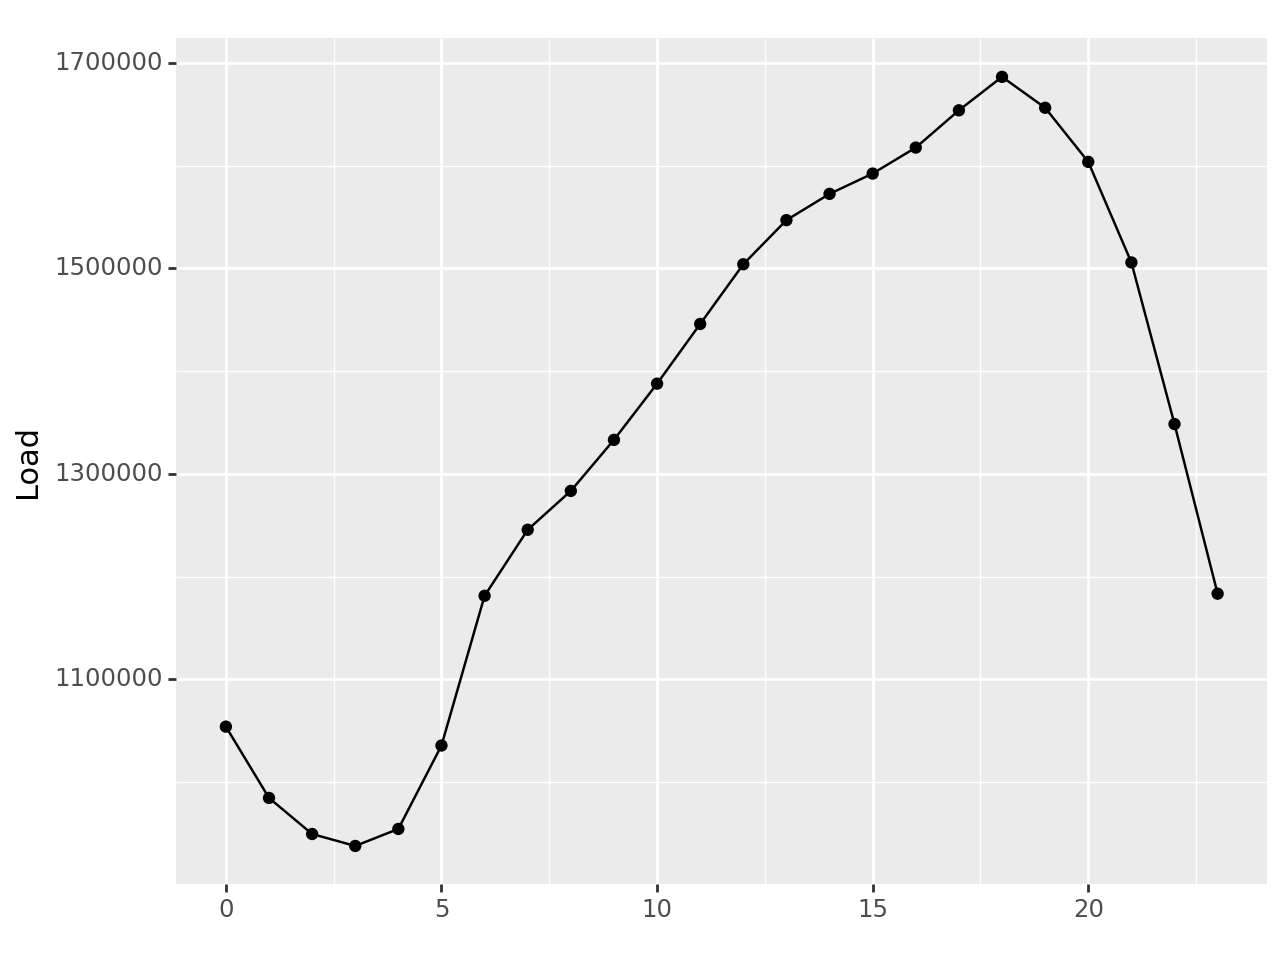

<Figure Size: (640 x 480)>

In [22]:
df_grpHours = df_new[['Load','Tavg','Hour']]
df_grpHours = df_grpHours.groupby('Hour').mean()
ggplot(df_grpHours, aes(df_grpHours.index, 'Load')) + geom_point() + geom_line()

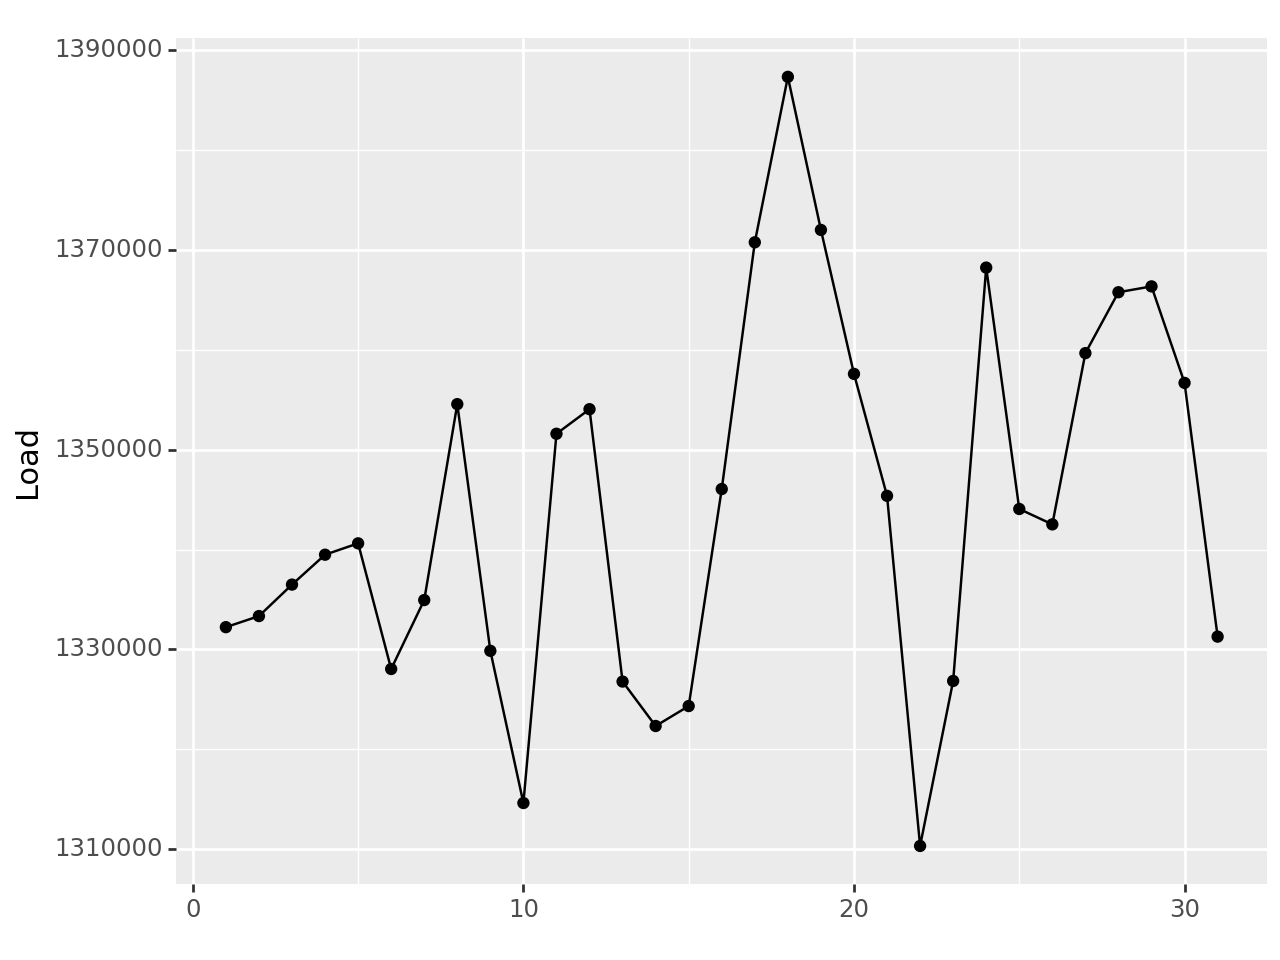

<Figure Size: (640 x 480)>

In [23]:
df_grpDays = df_new[['Load','Tavg','Day']]
df_grpDays = df_grpDays.groupby('Day').mean()
ggplot(df_grpDays, aes(df_grpDays.index, 'Load')) + geom_point() + geom_line()

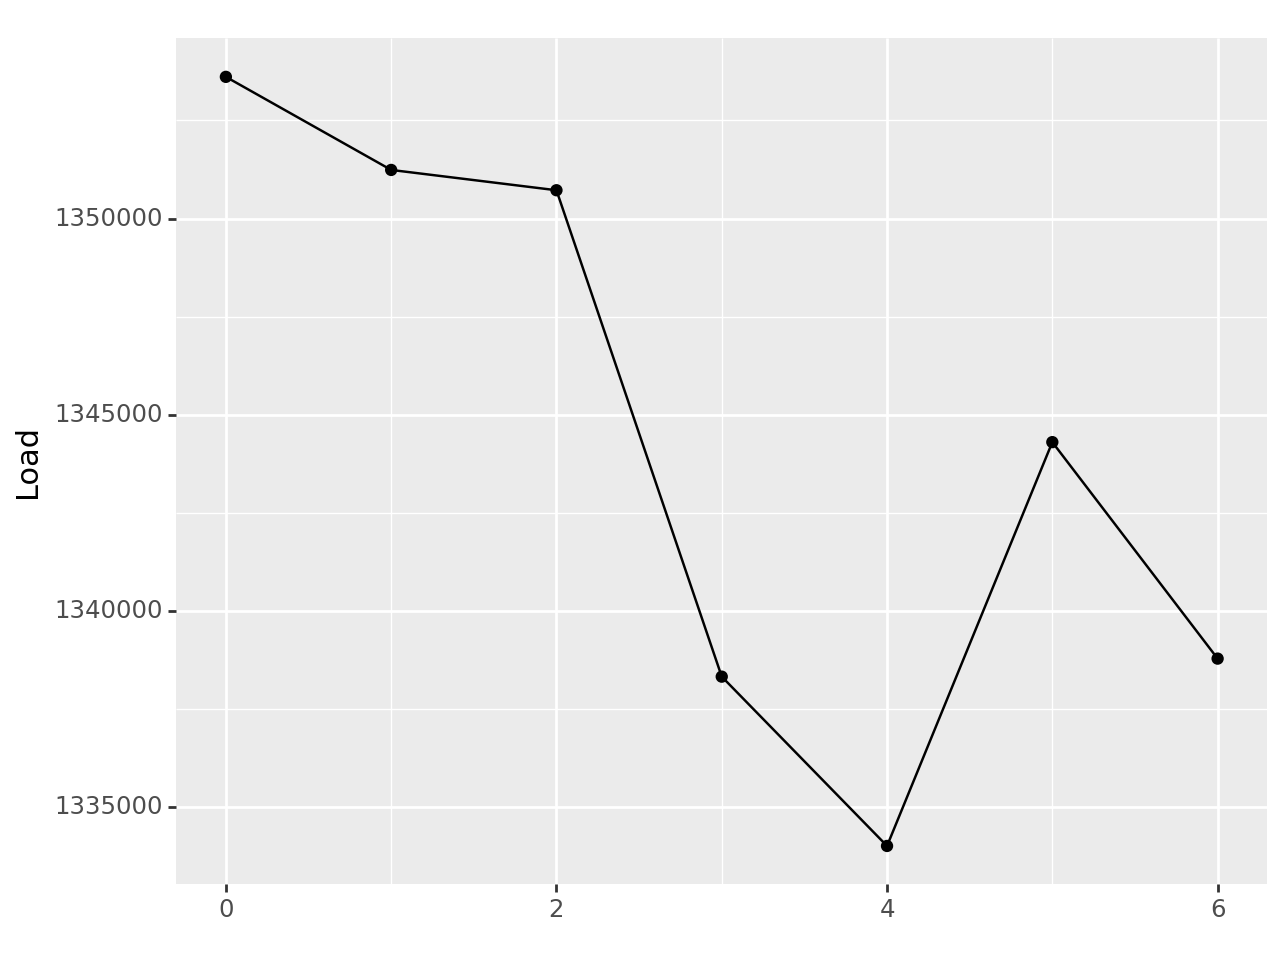

<Figure Size: (640 x 480)>

In [24]:
df_grpDayOW = df_new[['Load','Tavg','Day_of_week']]
df_grpDayOW = df_grpDayOW.groupby('Day_of_week').mean()
ggplot(df_grpDayOW, aes(df_grpDayOW.index, 'Load')) + geom_point() + geom_line()

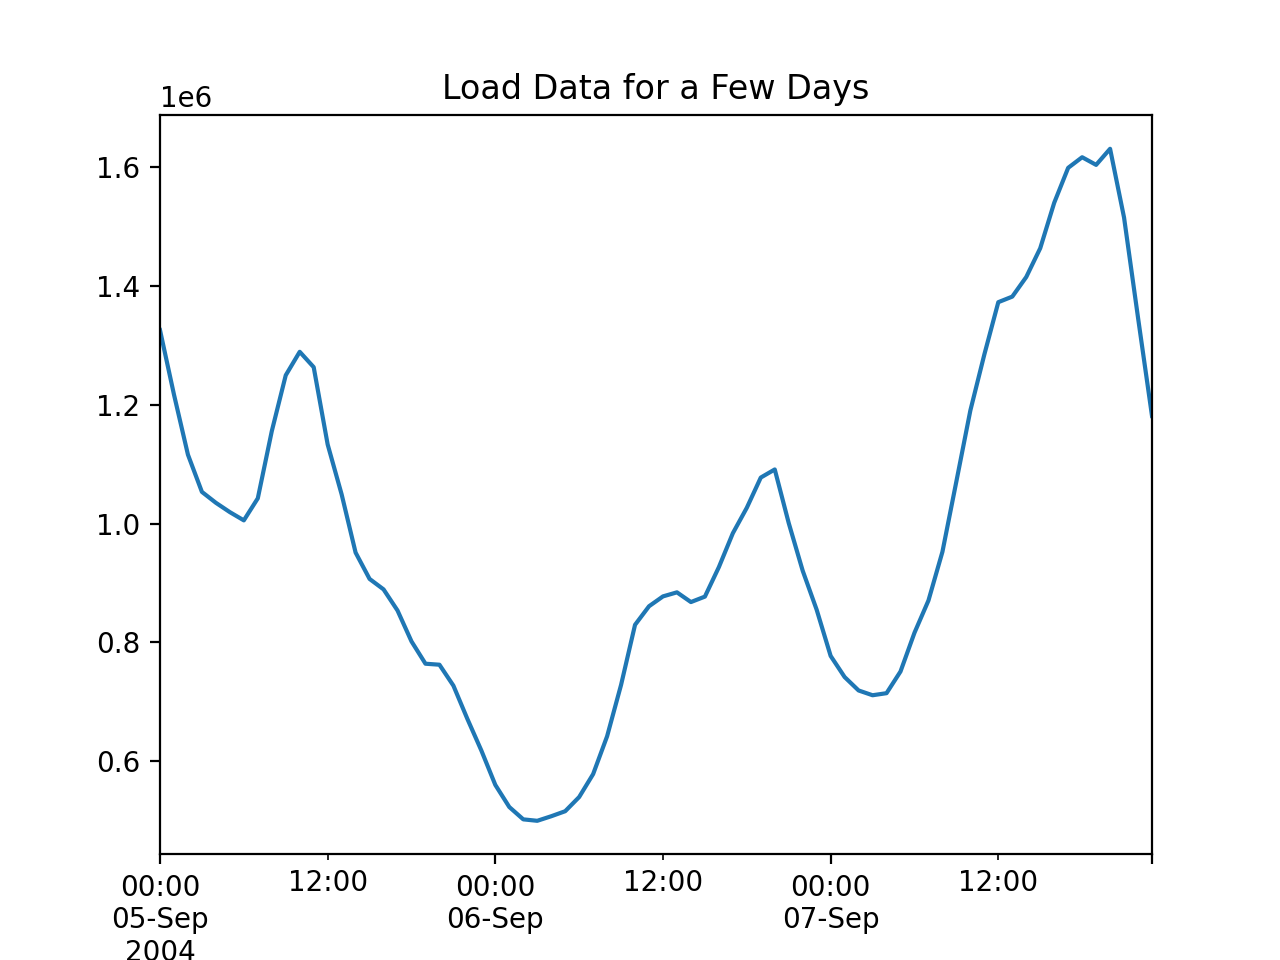

In [30]:
# df_new['Load']['2002-01-01 00:00:00':'2002-01-04 00:00:00'].plot(title='Load Data for a Few Days')
df_indexed.loc['2004-09-05 00:00:00':'2004-09-07 23:00:00']['Load'].plot(title='Load Data for a Few Days')
plt.axvline(x='2002-01-02 00:00:00', color='r', linestyle='-')
plt.axvline(x='2002-01-03 00:00:00', color='r', linestyle='-')
plt.show()

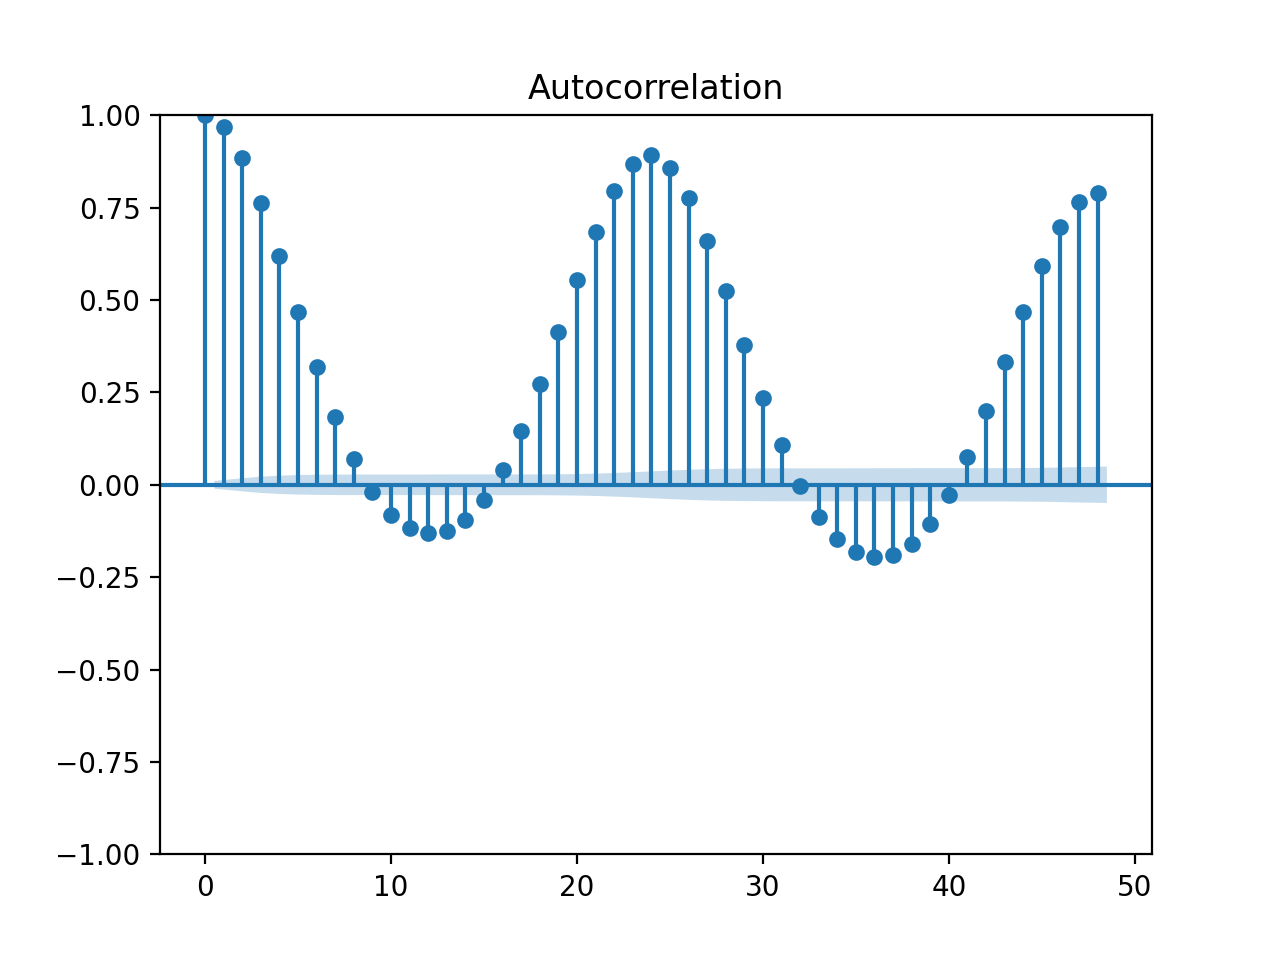

In [31]:
data = df_new.dropna()
plot_acf(data['Load'], lags=48)  # Change lags according to your data frequency
plt.show()

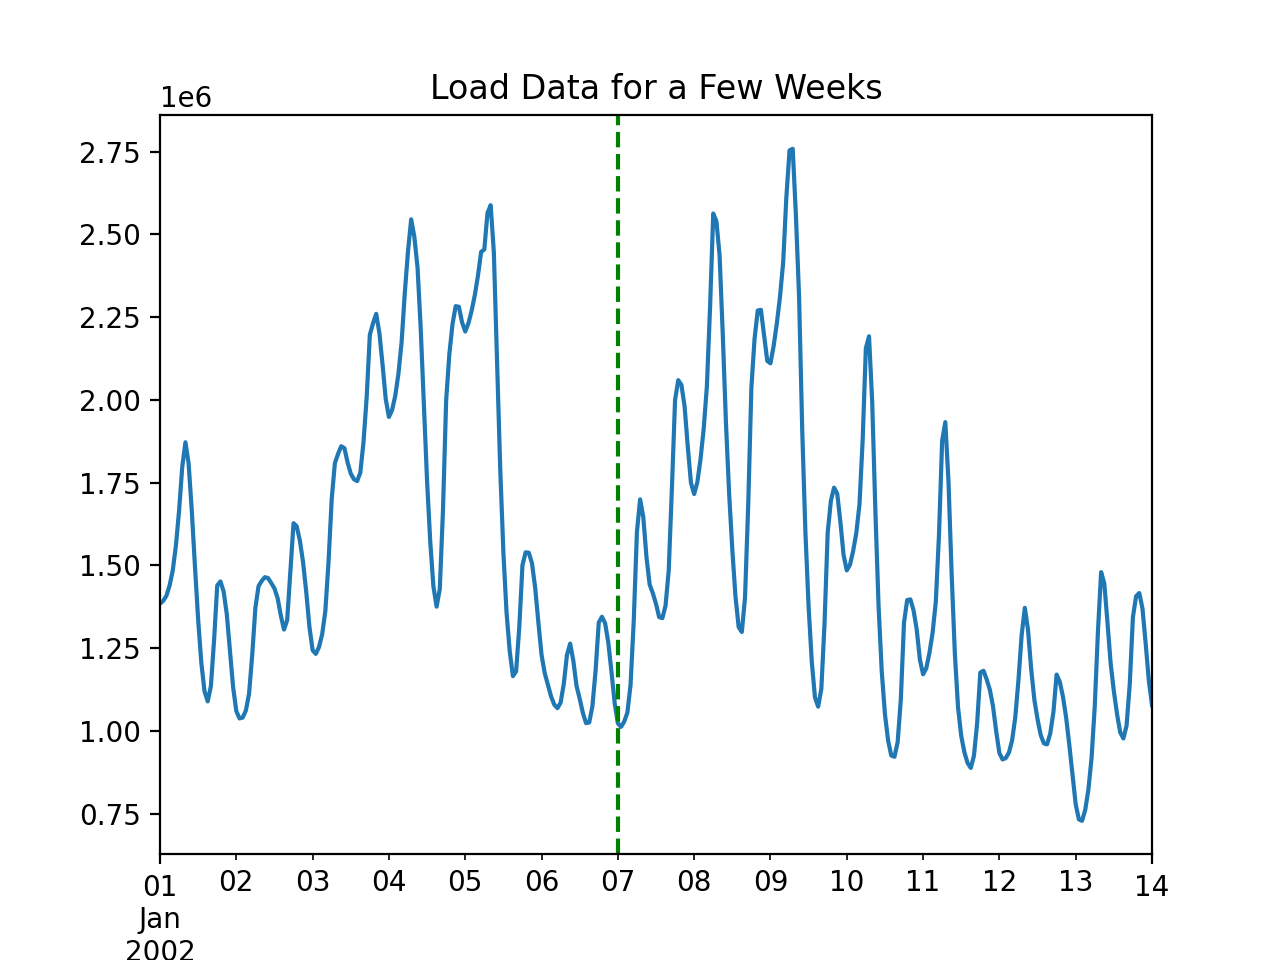

In [32]:
# df_new['Load']['2002-01-01 00:00:00':'2002-01-14 00:00:00'].plot(title='Load Data for a Few Weeks')
df_indexed.loc['2002-01-01 00:00:00':'2002-01-14 00:00:00']['Load'].plot(title='Load Data for a Few Weeks')
plt.axvline(x='2002-01-07 00:00:00', color='g', linestyle='--') #1 week mark
plt.show()

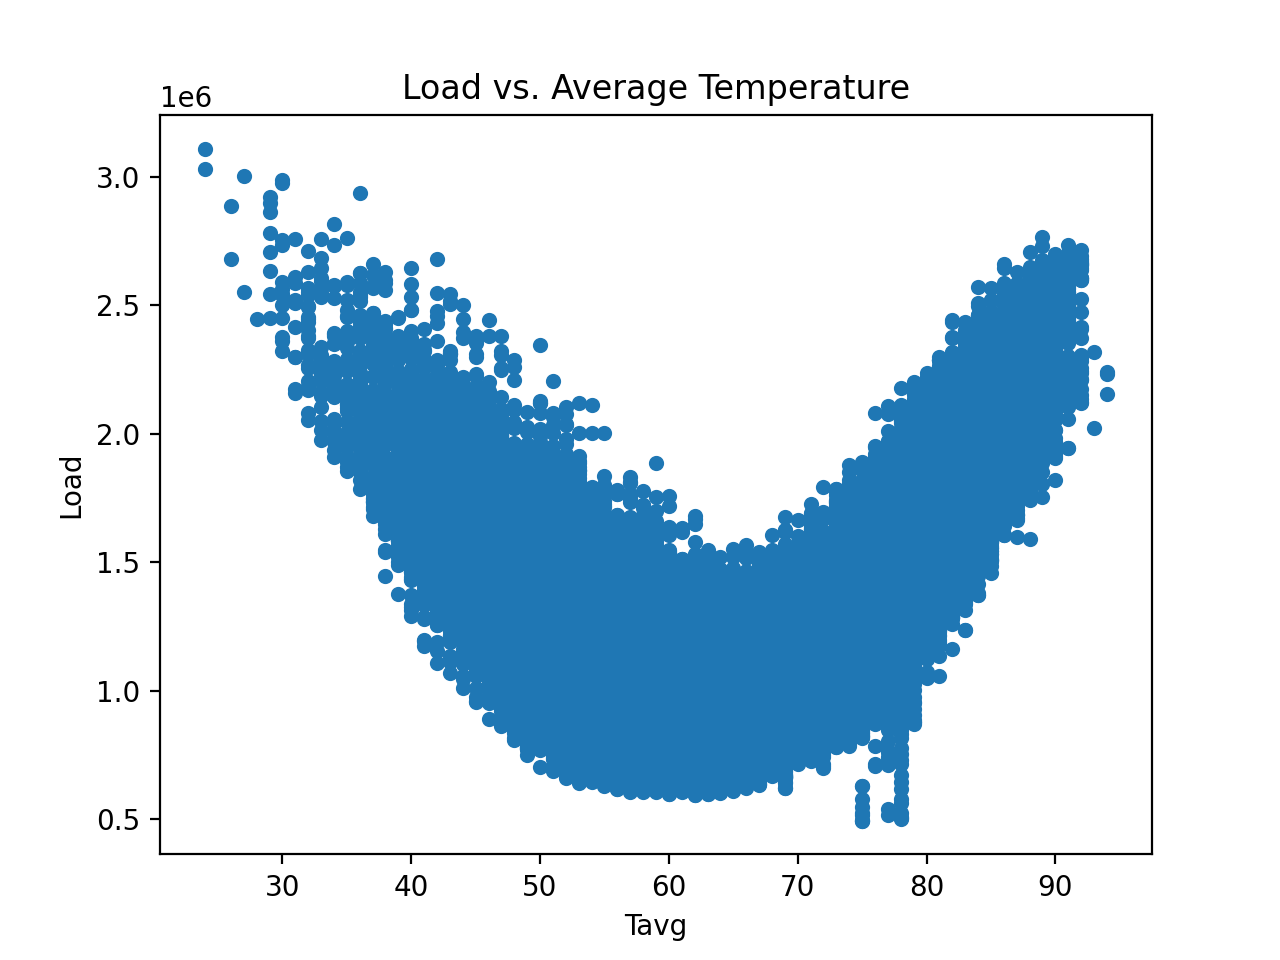

In [33]:
df_new.plot(x='Tavg', y='Load', kind='scatter', title='Load vs. Average Temperature')
plt.show()

## Early Modeling

In [ ]:
df_new.loc[2323:2332]

In [ ]:
M1 = smf.ols('Load ~ Tavg +  Tmed + Tmax + Tmin + C(Weekend) + C(Holiday) + C(Day_of_week) + C(Day) + C(Week) + C(Month) + C(Year) + Daily_Increase -1', data = df_new.loc[:35063]).fit()
print(M1.summary2())

## Additional Regression Options

In [ ]:
df_new['TavgR2'] = df_new['Tavg']*df_new['Tavg']
df_new['TavgR3'] = df_new['Tavg']*df_new['Tavg']*df_new['Tavg']
df_new['TavgR4'] = df_new['Tavg']*df_new['Tavg']*df_new['Tavg']*df_new['Tavg']
df_new

## Recommended Models

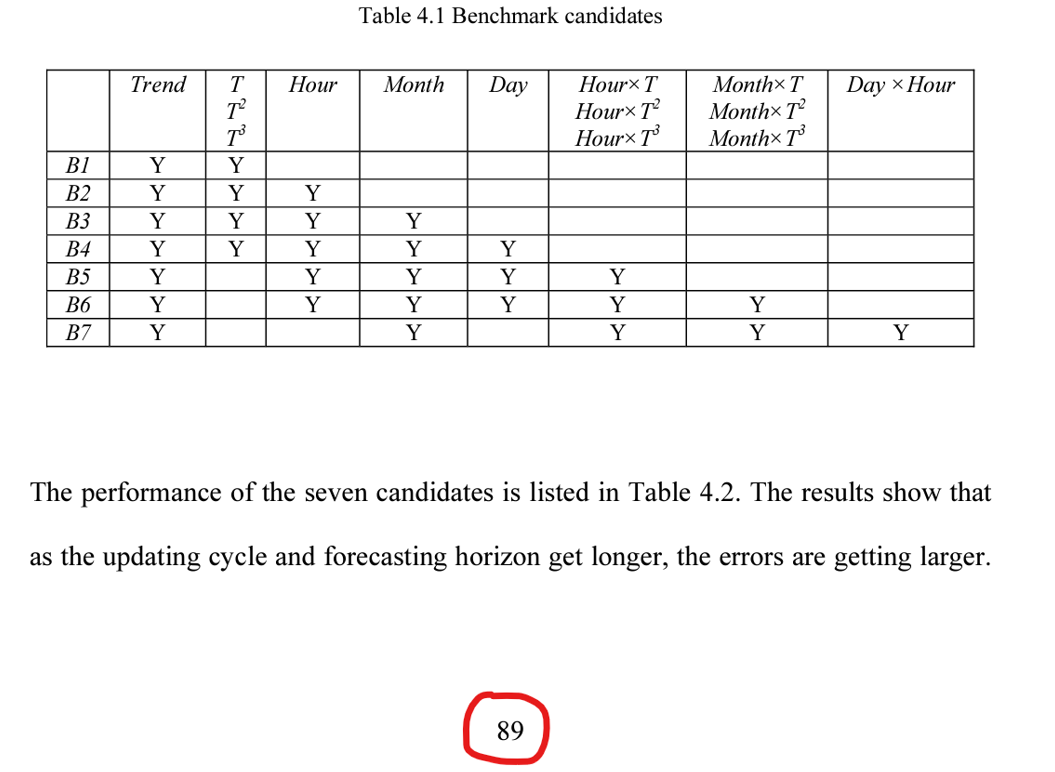

In [ ]:
B1 = smf.ols('Load ~ Tavg + TavgR2 + TavgR3 + Daily_Increase', data = df_new.loc[:35063]).fit()
print(B1.summary2())

In [ ]:
B2 = smf.ols('Load ~ Tavg + TavgR2 + TavgR3 + C(Hour) + Daily_Increase', data = df_new.loc[:35063]).fit()
print(B2.summary2())

In [ ]:
B3 = smf.ols('Load ~ Tavg + TavgR2 + TavgR3 + C(Hour) + C(Month) + Daily_Increase', data = df_new.loc[:35063]).fit()
print(B3.summary2())

In [ ]:
B4 = smf.ols('Load ~ Tavg + TavgR2 + TavgR3 + C(Hour) + C(Month) + C(Day_of_week) + Daily_Increase', data = df_new.loc[:35063]).fit()
print(B4.summary2())

In [ ]:
B5 = smf.ols('Load ~ Tavg:C(Hour) + TavgR2:C(Hour) + TavgR3:C(Hour) + C(Hour) + C(Month) + C(Day_of_week) + Daily_Increase', data = df_new.loc[:35063]).fit()
print(B5.summary2())

In [ ]:
B6 = smf.ols('Load ~ Tavg:C(Hour) + TavgR2:C(Hour) + TavgR3:C(Hour) + Tavg:C(Month) + TavgR2:C(Month) + TavgR3:C(Month) + C(Hour) + C(Month) + C(Day_of_week) + Daily_Increase', data = df_new.loc[:35063]).fit()
print(B6.summary2())

In [ ]:
B7 = smf.ols('Load ~ Tavg:C(Hour) + TavgR2:C(Hour) + TavgR3:C(Hour) + Tavg:C(Month) + TavgR2:C(Month) + TavgR3:C(Month) + C(Hour):C(Day_of_week) + C(Month) + Daily_Increase', data = df_new.loc[:35063]).fit()
print(B7.summary2())

## Personal Models

In [ ]:
df_new.loc[12345]

Notes:


1.   First Run: B6, no day, yes day_of_week -> R2 = .950
2.   Second Run: First, but with Tag^4*Hour -> R2 = .951
3.   Third Run: Second, but with Tag^4*Month -> R2 = .951
4.   Fourth Run:
5.   Fifth Run:
6.   Sixth Run:
7.   Seventh Run:
8.   Eighth Run:



## Advanced Models

In [ ]:
Mine1 = smf.ols('Load ~ Tavg:C(Hour) + TavgR2:C(Hour) + TavgR3:C(Hour) + TavgR4:C(Hour) + Tavg:C(Month) + TavgR2:C(Month) + TavgR3:C(Month) + TavgR4:C(Month) + C(Hour):C(Day_of_week) + C(Month) + Daily_Increase', data = df_new.loc[:35063]).fit()
print(Mine1.summary2())

In [ ]:
# df['Mine1'] = Mine1.predict(df)
# df['Mine1residuals'] = Mine1.resid
residuals = Mine1.resid
# df['M1residuals']
# Plotting (Next to each other)
fig, axes = plt.subplots(1,3,figsize=(25,5))
residuals.plot(ax=axes[0],title='Residuals')
axes[0].axhline(0,color='black')
plot_acf(residuals,missing='drop',zero=False,ax=axes[1]);
plot_pacf(residuals.dropna(),zero=False,ax=axes[2]);

In [ ]:
df_new['Tavg_lag1'] = df_new['Tavg'].shift(1)
df_new['Tavg_lag2'] = df_new['Tavg'].shift(2)
df_new['Tavg_lag24'] = df_new['Tavg'].shift(24)
df_new['Tavg_lag1R2'] = df_new['Tavg_lag1']*df_new['Tavg_lag1']
df_new['Tavg_lag1R3'] = df_new['Tavg_lag1']*df_new['Tavg_lag1']*df_new['Tavg_lag1']
df_new['Tavg_lag2R2'] = df_new['Tavg_lag2']*df_new['Tavg_lag2']
df_new['Tavg_lag2R3'] = df_new['Tavg_lag2']*df_new['Tavg_lag2']*df_new['Tavg_lag2']
df_new['Tavg_lag24R2'] = df_new['Tavg_lag24']*df_new['Tavg_lag24']
df_new['Tavg_lag24R3'] = df_new['Tavg_lag24']*df_new['Tavg_lag24']*df_new['Tavg_lag24']
# df_new['lag21']

In [ ]:
Mine2 = smf.ols('Load ~ Tavg:C(Hour) + TavgR2:C(Hour) + TavgR3:C(Hour) \
                 + Tavg:C(Month) + TavgR2:C(Month) + TavgR3:C(Month) + \
                 C(Hour):C(Day_of_week) + C(Month) + \
                 Tavg_lag1:C(Hour) + Tavg_lag1R2:C(Hour) + Tavg_lag1R3:C(Hour) \
                 + Tavg_lag1:C(Month) + Tavg_lag1R2:C(Month) + Tavg_lag1R3:C(Month) + \
                 Tavg_lag2:C(Hour) + Tavg_lag2R2:C(Hour) + Tavg_lag2R3:C(Hour) \
                 + Tavg_lag2:C(Month) + Tavg_lag2R2:C(Month) + Tavg_lag2R3:C(Month) + \
                 Tavg_lag24:C(Hour) + Tavg_lag24R2:C(Hour) + Tavg_lag24R3:C(Hour) \
                 + Tavg_lag24:C(Month) + Tavg_lag24R2:C(Month) + Tavg_lag24R3:C(Month) + \
                 Daily_Increase', data = df_new.loc[:35063]).fit()
print(Mine2.summary2())

In [ ]:
# df['Mine1'] = Mine1.predict(df)
# df['Mine1residuals'] = Mine1.resid
residuals2 = Mine2.resid
# df['M1residuals']
# Plotting (Next to each other)
fig, axes = plt.subplots(1,3,figsize=(25,5))
residuals2.plot(ax=axes[0],title='Residuals')
axes[0].axhline(0,color='black')
plot_acf(residuals2,missing='drop',zero=False,ax=axes[1]);
plot_pacf(residuals2.dropna(),zero=False,ax=axes[2]);

In [ ]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vifTable = pd.DataFrame(columns = ['VIF'], index = ["Tavg:C(Hour)", "TavgR2:C(Hour)", "TavgR3:C(Hour)", \
#                  "Tavg:C(Month)","TavgR2:C(Month)", "TavgR3:C(Month)", \
#                  "C(Hour):C(Day_of_week)", "C(Month)", \
#                  "Tavg_lag1:C(Hour)", "Tavg_lag1R2:C(Hour)", "Tavg_lag1R3:C(Hour)", \
#                  "Tavg_lag1:C(Month)", "Tavg_lag1R2:C(Month)", "Tavg_lag1R3:C(Month)", \
#                  "Tavg_lag2:C(Hour)", "Tavg_lag2R2:C(Hour)", "Tavg_lag2R3:C(Hour)", \
#                  "Tavg_lag2:C(Month)", "Tavg_lag2R2:C(Month)", "Tavg_lag2R3:C(Month)", \
#                  "Tavg_lag24:C(Hour)", "Tavg_lag24R2:C(Hour)", "Tavg_lag24R3:C(Hour)", \
#                  "Tavg_lag24:C(Month)", "Tavg_lag24R2:C(Month)", "Tavg_lag24R3:C(Month)", \
#                  "Daily_Increase"])
# X = Mine2.model.exog
# vif = [variance_inflation_factor(X,i) for i in range(1, X.shape[1])]
# vifTable['VIF'] = vif
# vifTable

## Notes with Robertas

Look at ccf, between load and lags of temperature

For pacf and acf, these will likely not be greatly informative given there is an assumption of linearity that may not theoretically hold.

In [ ]:
# import statsmodels.api as sm
# sm.tsa.stattools.ccf(df1['your_column'], df2['your_column'], unbiased=True)

Introducing lags does create the opportunity for multicollinearity, and will be quite high. Thinking through GPA and SAT score and their relation.

Generally: we are not focusing on any analysis of these models, we are largely prioritizing the future predictions. Focus on MAPE, focus on RMSE, not R-squared.

## Continues

In [ ]:
Mine3 = smf.ols('Load ~ Tavg:C(Hour) + TavgR2:C(Hour) + TavgR3:C(Hour) + TavgR4:C(Hour) \
                 + Tavg:C(Month) + TavgR2:C(Month) + TavgR3:C(Month) + TavgR4:C(Month) \
                 + C(Hour):C(Day_of_week) + C(Month) \
                 + C(iga79) + C(iga80) + C(iga81) + C(iga82) \
                 + C(igb40) + C(igb45) \
                 + Daily_Increase', data = df_new.loc[:35063]).fit()
print(Mine3.summary2())

In [ ]:
df_new['Load_lag1'] = df_new['Load'].shift(1)
df_new['Load_lag2'] = df_new['Load'].shift(2)
df_new['Load_lag24'] = df_new['Load'].shift(24)
df_new['Load_lagyear'] = df_new['Load'].shift(8760)

In [ ]:
Mine4 = smf.ols('Load ~ Tavg:C(Hour) + TavgR2:C(Hour) + TavgR3:C(Hour) \
                 + Tavg:C(Month) + TavgR2:C(Month) + TavgR3:C(Month) + \
                 C(Hour):C(Day_of_week) + C(Month) + \
                 Tavg_lag1:C(Hour) + Tavg_lag1R2:C(Hour) + Tavg_lag1R3:C(Hour) \
                 + Tavg_lag1:C(Month) + Tavg_lag1R2:C(Month) + Tavg_lag1R3:C(Month) + \
                 Tavg_lag2:C(Hour) + Tavg_lag2R2:C(Hour) + Tavg_lag2R3:C(Hour) \
                 + Tavg_lag2:C(Month) + Tavg_lag2R2:C(Month) + Tavg_lag2R3:C(Month) + \
                 Tavg_lag24:C(Hour) + Tavg_lag24R2:C(Hour) + Tavg_lag24R3:C(Hour) \
                 + Tavg_lag24:C(Month) + Tavg_lag24R2:C(Month) + Tavg_lag24R3:C(Month) + \
                 Load_lagyear \
                 + C(iga79) + C(iga80) + C(iga81) + C(iga82) \
                 + C(igb40) + C(igb45) + \
                 Daily_Increase', data = df_new.loc[:35063]).fit()
print(Mine4.summary2())

In [ ]:
Mine5 = smf.ols('Load ~ Tavg:C(Hour) + TavgR2:C(Hour) + TavgR3:C(Hour) \
                 + Tavg:C(Month) + TavgR2:C(Month) + TavgR3:C(Month) + \
                 C(Hour):C(Day_of_week) + C(Month) + \
                 Load_lagyear \
                 + C(iga79) + C(iga80) + C(iga81) + C(iga82) \
                 + C(igb40) + C(igb45) + \
                 Daily_Increase', data = df_new.loc[:35063]).fit()
print(Mine5.summary2())

In [ ]:
Mine6 = smf.ols('Load ~ Tavg:C(Hour) + TavgR2:C(Hour) + TavgR3:C(Hour) \
                 + Tavg:C(Month) + TavgR2:C(Month) + TavgR3:C(Month) + \
                 C(Hour):C(Day_of_week) + C(Month) + \
                 Tavg_lag1:C(Hour) + Tavg_lag1R2:C(Hour) + Tavg_lag1R3:C(Hour) \
                 + Tavg_lag1:C(Month) + Tavg_lag1R2:C(Month) + Tavg_lag1R3:C(Month) + \
                 Tavg_lag2:C(Hour) + Tavg_lag2R2:C(Hour) + Tavg_lag2R3:C(Hour) \
                 + Tavg_lag2:C(Month) + Tavg_lag2R2:C(Month) + Tavg_lag2R3:C(Month) + \
                 Tavg_lag24:C(Hour) + Tavg_lag24R2:C(Hour) + Tavg_lag24R3:C(Hour) \
                 + Tavg_lag24:C(Month) + Tavg_lag24R2:C(Month) + Tavg_lag24R3:C(Month) + \
                 Load_lag1 + Load_lag2 + Load_lag24 + Load_lagyear \
                 + C(iga79) + C(iga80) + C(iga81) + C(iga82) \
                 + C(igb40) + C(igb45) + \
                 Daily_Increase', data = df_new.loc[:35063]).fit()
print(Mine6.summary2())

In [ ]:
Mine7 = smf.ols('Load ~ Tavg:C(Hour) + TavgR2:C(Hour) + TavgR3:C(Hour) \
                 + Tavg:C(Month) + TavgR2:C(Month) + TavgR3:C(Month) + \
                 C(Hour):C(Day_of_week) + C(Month) + \
                 Tavg_lag1:C(Hour) + Tavg_lag1R2:C(Hour) + Tavg_lag1R3:C(Hour) \
                 + Tavg_lag1:C(Month) + Tavg_lag1R2:C(Month) + Tavg_lag1R3:C(Month) + \
                 Tavg_lag2:C(Hour) + Tavg_lag2R2:C(Hour) + Tavg_lag2R3:C(Hour) \
                 + Tavg_lag2:C(Month) + Tavg_lag2R2:C(Month) + Tavg_lag2R3:C(Month) + \
                 Tavg_lag24:C(Hour) + Tavg_lag24R2:C(Hour) + Tavg_lag24R3:C(Hour) \
                 + Tavg_lag24:C(Month) + Tavg_lag24R2:C(Month) + Tavg_lag24R3:C(Month) + \
                 Load_lagyear + C(Holiday) + C(outliers) \
                 + C(iga79) + C(iga80) + C(iga81) + C(iga82) \
                 + C(igb40) + C(igb45) + \
                 Daily_Increase', data = df_new.loc[:35063]).fit()
print(Mine7.summary2())

In [ ]:
Champ = smf.ols('Load ~ Tavg:C(Hour) + TavgR2:C(Hour) + TavgR3:C(Hour) \
                 + Tavg:C(Month) + TavgR2:C(Month) + TavgR3:C(Month) + \
                 C(Hour):C(Day_of_week) + C(Month) + \
                 Tavg_lag1:C(Hour) + Tavg_lag1R2:C(Hour) + Tavg_lag1R3:C(Hour) \
                 + Tavg_lag1:C(Month) + Tavg_lag1R2:C(Month) + Tavg_lag1R3:C(Month) + \
                 Tavg_lag2:C(Hour) + Tavg_lag2R2:C(Hour) + Tavg_lag2R3:C(Hour) \
                 + Tavg_lag2:C(Month) + Tavg_lag2R2:C(Month) + Tavg_lag2R3:C(Month) + \
                 Tavg_lag24:C(Hour) + Tavg_lag24R2:C(Hour) + Tavg_lag24R3:C(Hour) \
                 + Tavg_lag24:C(Month) + Tavg_lag24R2:C(Month) + Tavg_lag24R3:C(Month) + \
                 Load_lagyear + C(Holiday) + C(outliers1) + C(outliers2)\
                 + C(iga79) + C(iga80) + C(iga81) + C(iga82) \
                 + C(igb40) + C(igb45) + \
                 Daily_Increase', data = df_new.loc[:35063]).fit()
print(Champ.summary2())

## Export

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_new.loc[26384:26388]

In [ ]:
# df_new['Predictions'] = predicition
predictions = Champ.predict(df_new)
# predictions2 = Mine6.predict(df_new)
# df_temp = df_new[['Hours', 'Tavg', 'Load']]

# from google.colab import drive
# drive.mount('/content/drive')
with pd.ExcelWriter("/content/drive/Shareddrives/DSO 424/Prediction.xlsx") as writer:
        predictions.to_excel(writer, index = False, sheet_name = "Champ Prediction")
        # predictions2.to_excel(writer, index = False, sheet_name = "Seventh Prediction")


So far:

Mine3: 5.55

B7: 5.73 or .74

Mine2: 4.74

Mine4: 4.40

Mine5: 5.39

Mine6: Not possible, lag cycle is too small

Mine7: 4.33

include holidays again for shits and giggles

# New Section